### Complejidad - Práctico 6 - Criticalidad auto organizada en crashes financieros
#### Lautaro Giordano
En este trabajo voy a explorar la aparición de criticalidad en series temporales de precios de instrumentos financieros y criptomonedas. Las "avalanchas" en este caso serían la fluctuaciones del precio en un período muy corto de tiempo, dado por mucha gente que sin haberse puesto de acuerdo decide comprar o vender estos activos en masa en un período muy corto de tiempo (que se conocen como crashes). Estos crashes o avalanchas tienen magnitudes distintas, y pueden ser generados o aunque sea influenciados por factores diversos como el estallido de una guerra, la imposición de sanciones económicas o impuestos, resultados de elecciones, acciones con sobreprecio que terminan en la explosión de una burbuja, etc. En lo que sigue voy a trabajar con dos instrumentos muy distintos: el índice S&P500 (como un MERVAL pero de las 500 empresas más importantes de estados unidos), y ya que estamos, voy a usar el precio del bitcoin, que tiene una volatibilidad mucho mayor.

In [3]:
import numpy as np
from matplotlib import pyplot as plt
# yfinance es la libreria de yahoo finance que tiene datos historicos de acciones
import yfinance as yf
# La librería PyWavelets es para hacer la transformada wavelet de los datos
import pywt
from scipy import stats
import pandas as pd

In [4]:
# Descarga los datos históricos del S&P 500
ticker = "^GSPC"  # Símbolo del S&P 500 en Yahoo Finance
sp500 = yf.download(ticker, start='1980-01-01', end=None, interval="1d")

# Mostrar las primeras filas de los datos
sp500.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
1980-01-02,105.760002,105.760002,108.430000,105.290001,0.0,40610000
1980-01-03,105.220001,105.220001,106.080002,103.260002,0.0,50480000
1980-01-04,106.519997,106.519997,107.080002,105.089996,0.0,39130000
1980-01-07,106.809998,106.809998,107.800003,105.800003,0.0,44500000
1980-01-08,108.949997,108.949997,109.290001,106.290001,0.0,53390000


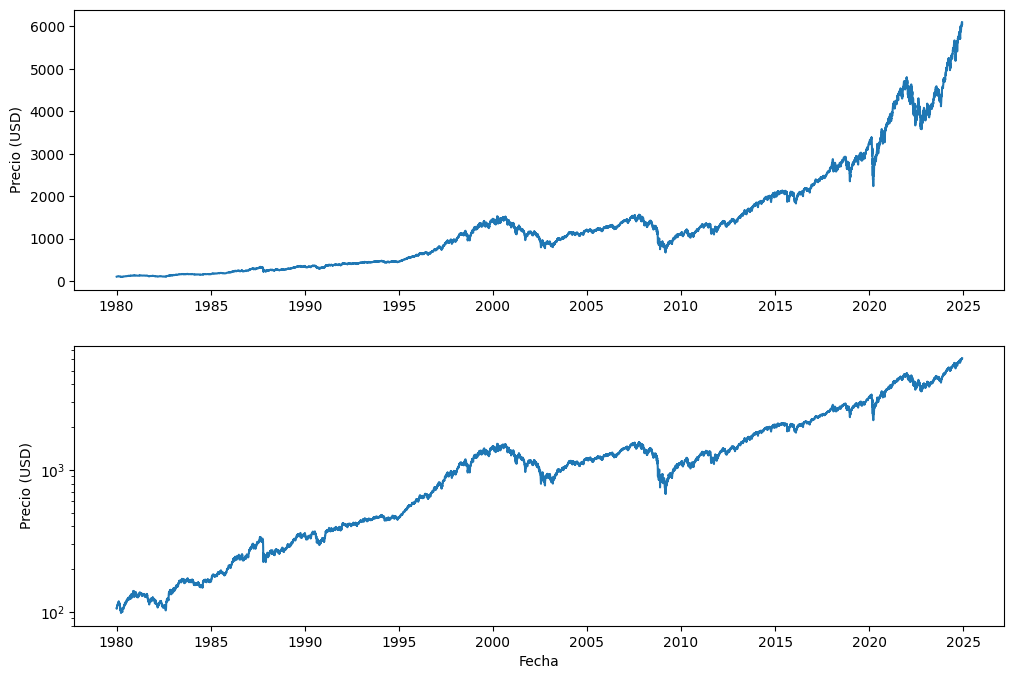

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
# Adj Close es el precio de cierre.
ax1.plot(sp500["Adj Close"])
ax2.plot(sp500["Adj Close"])
ax1.set_ylabel("Precio (USD)")
ax2.set_xlabel("Fecha")
ax2.set_ylabel("Precio (USD)")
ax2.set_yscale("log")

Existen ciertos eventos donde el cambio de precio relativo es muy alto en un período de tiempo muy corto, esos son los crashes. Veamos los más importantes más de cerca.

Text(0, 0.5, 'Precio (USD)')

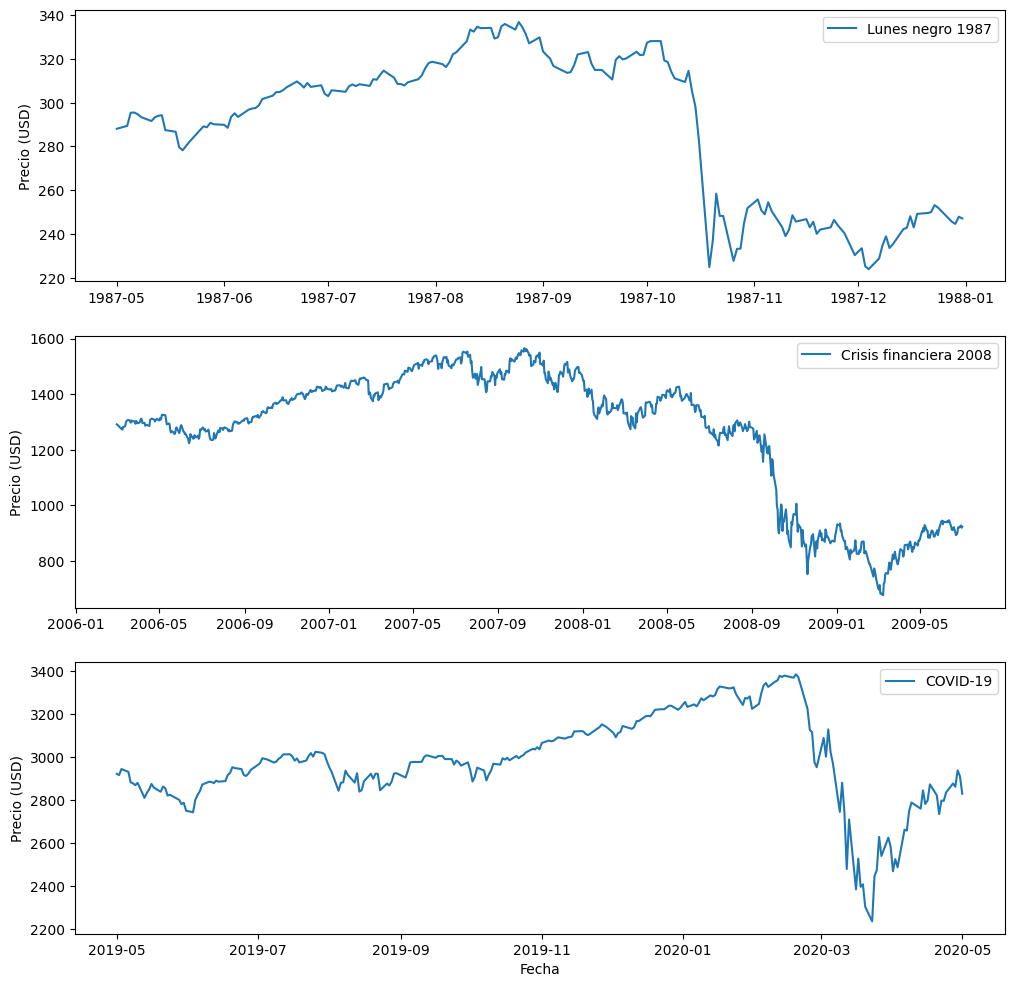

In [11]:
# Muestro los crashes de 1987, 2008 y 2020
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
ax1.plot(sp500["Adj Close"]["1987-05-01":"1988-01-01"], label="Lunes negro 1987")
ax2.plot(sp500["Adj Close"]["2006-03-01":"2009-07-01"], label="Crisis financiera 2008")
ax3.plot(sp500["Adj Close"]["2019-05-01":"2020-05-01"], label="COVID-19")
ax1.legend()
ax2.legend()
ax3.legend()
ax3.set_xlabel("Fecha")
ax1.set_ylabel("Precio (USD)")
ax2.set_ylabel("Precio (USD)")
ax3.set_ylabel("Precio (USD)")

Estos gráficos nos sirven para ver que no solo la magnitud es variable, sino también la escala temporal en la que suceden estos crashes. Por ejemplo, la crisis financiera del 2008 persistió por meses a poco más de un año, donde la acción cayó alrededor de un $50%$, mientras que en el lunes negro los mercados financieros tuvieron una caída de alredor del $26%$ en un único día.

Price                       Adj Close Log Return
Ticker                          ^GSPC           
Date                                            
1980-01-03 00:00:00+00:00  105.220001  -0.005119
1980-01-04 00:00:00+00:00  106.519997   0.012279
1980-01-07 00:00:00+00:00  106.809998   0.002719
1980-01-08 00:00:00+00:00  108.949997   0.019838
1980-01-09 00:00:00+00:00  109.050003   0.000917


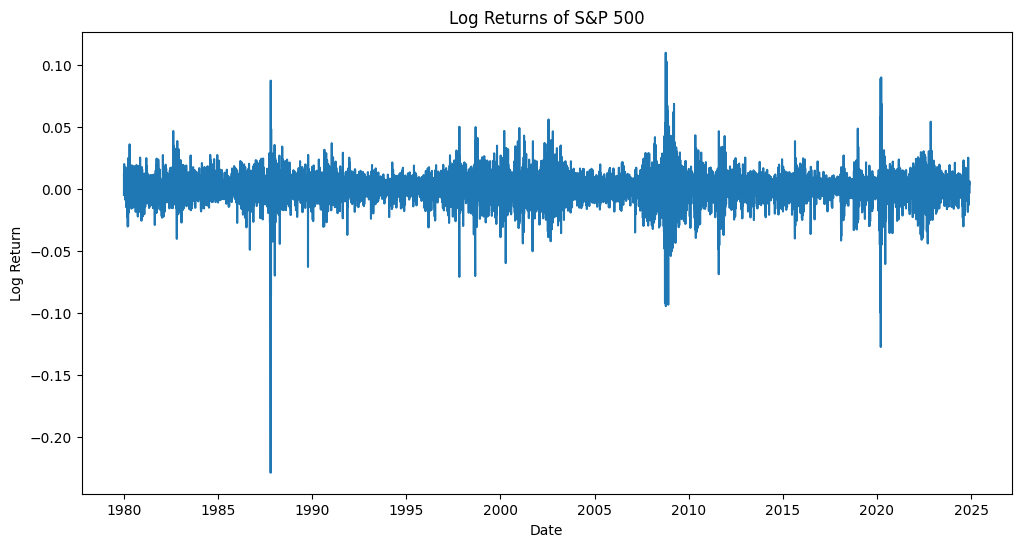

In [6]:
# Calcular los retornos logarítmicos
sp500['Log Return'] = np.log(sp500['Adj Close'] / sp500['Adj Close'].shift(1))

# Eliminar valores NaN resultantes del desplazamiento
sp500.dropna(inplace=True)

# Mostrar las primeras filas de los datos con retornos
print(sp500[['Adj Close', 'Log Return']].head())

# Graficar los retornos
plt.figure(figsize=(12, 6))
plt.plot(sp500['Log Return'])
plt.title('Log Returns of S&P 500')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

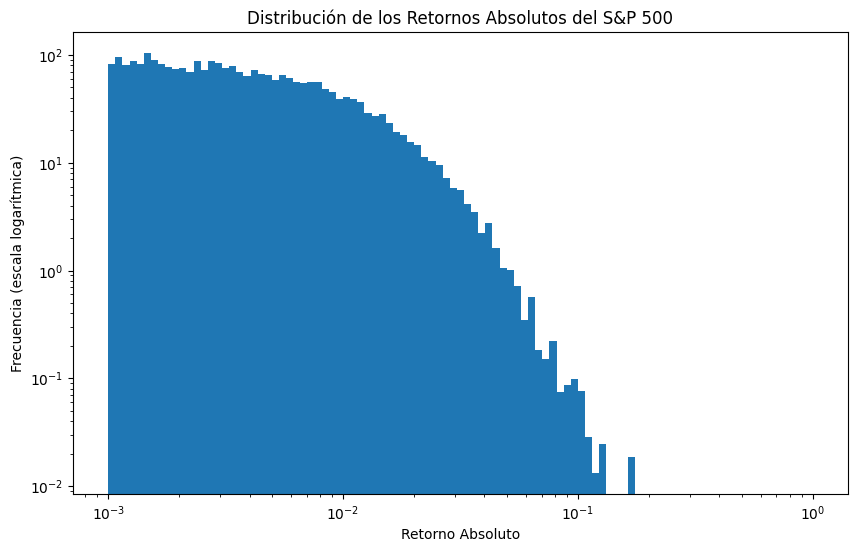

In [40]:
# Histograma de los retornos absolutos
plt.figure(figsize=(10, 6))

bins = np.logspace(-3, 0, 100)

plt.hist(np.abs(sp500['Log Return']), bins=bins, density=True)
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Retorno Absoluto")
plt.ylabel("Frecuencia (escala logarítmica)")
plt.title("Distribución de los Retornos Absolutos del S&P 500")
plt.show()

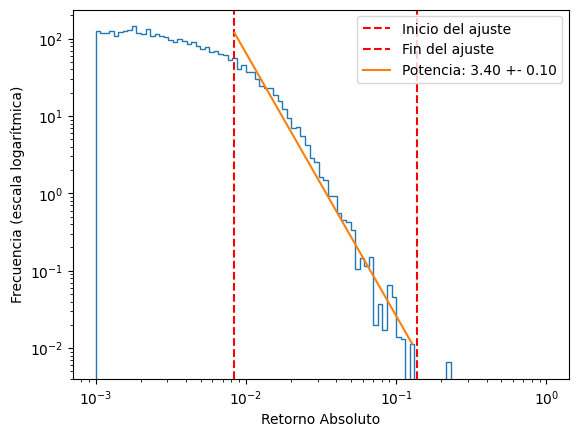

In [43]:
bins = np.logspace(-3, 0, 100)
counts, bins, _ = plt.hist(np.abs(sp500['Log Return']), bins=bins, density=True, histtype='step')
plt.xscale("log")
plt.yscale("log")

x = (bins[:-1] + bins[1:]) / 2

# Ajustar una distribución de potencia a los datos
start = 30
end = 70
plt.axvline(x[start], color='r', linestyle='--', label='Inicio del ajuste')
plt.axvline(x[end], color='r', linestyle='--', label='Fin del ajuste')

x_fit = x[start:end]
y_fit = counts[start:end]

# Borro los valores 0 para que no haya problemas al hacer el ajuste
x_fit = x_fit[y_fit > 0]
y_fit = y_fit[y_fit > 0]

popt, pcov = np.polyfit(np.log(x_fit), np.log(y_fit), 1, cov=True)
alpha = -popt[0]
beta = np.exp(popt[1])

plt.plot(x_fit, beta * x_fit ** (-alpha), label=f'Potencia: {alpha:.2f} +- {np.sqrt(pcov[0, 0]):.2f}')

plt.xlabel("Retorno Absoluto")
plt.ylabel("Frecuencia (escala logarítmica)");

plt.legend()


Miro ventanas diferentes a un solo día

In [ ]:
# Definir diferentes ventanas de tiempo (en días)
ventanas = [1, 5, 10, 20]  # 1 día, 1 semana, 2 semanas, 1 mes

for ventana in ventanas:
    sp500[f'Return_{ventana}d'] = np.log(sp500['Adj Close'] / sp500['Adj Close'].shift(ventana))

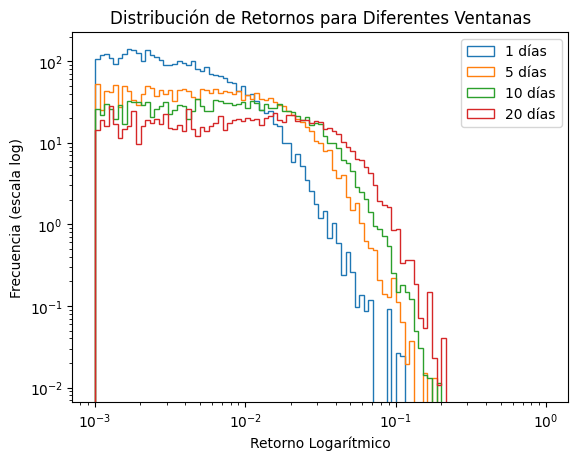

In [29]:
bins = np.logspace(-3, 0, 100)

# Graficar las distribuciones de los retornos para diferentes ventanas
# plt.figure(figsize=(12, 8))
for ventana in ventanas:
    plt.hist(sp500[f'Return_{ventana}d'].dropna(), bins=bins, label=f'{ventana} días', histtype='step', density=True)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Retorno Logarítmico")
plt.ylabel("Frecuencia (escala log)")
plt.title("Distribución de Retornos para Diferentes Ventanas")
plt.legend()
plt.show()


Probando el método de Wavelet del paper de Bartolozzi

Curtosis: 104.54927689419875
Asimetría: -2.5286579911951166


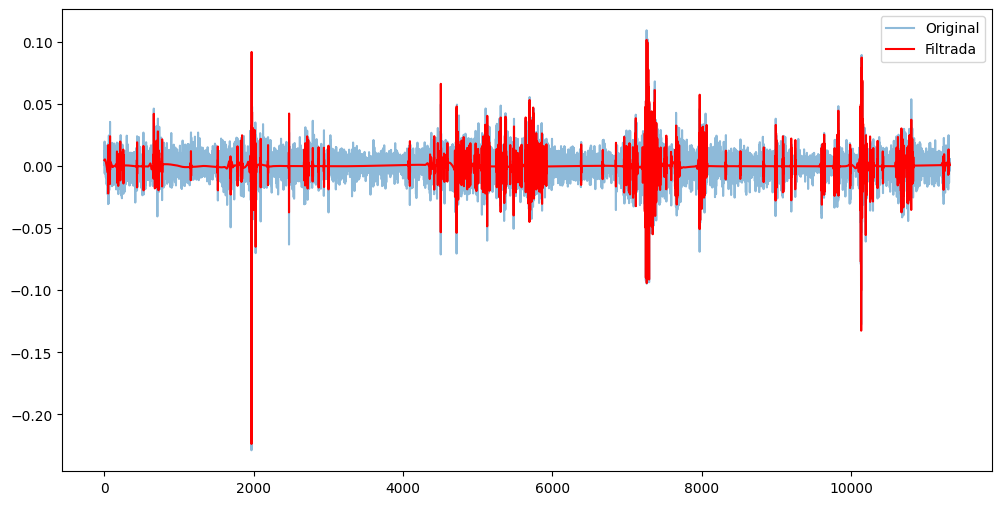

In [30]:
# Supón que 'log_returns' es tu serie temporal de retornos logarítmicos
log_returns = sp500['Log Return'].values

# Realiza la descomposición wavelet con la wavelet Daubechies de orden 4
wavelet = 'db4'
coeffs = pywt.wavedec(log_returns, wavelet)

# Filtra los coeficientes eliminando los de baja energía
threshold = 0.25 * np.max(coeffs[-1])  # Ajusta este umbral según sea necesario
filtered_coeffs = [pywt.threshold(c, threshold, mode='hard') for c in coeffs]

# Reconstruye la serie temporal filtrada
filtered_log_returns = pywt.waverec(filtered_coeffs, wavelet)

kurtosis = stats.kurtosis(filtered_log_returns)
skewness = stats.skew(filtered_log_returns)
print("Curtosis:", kurtosis)
print("Asimetría:", skewness)

# Graficar la serie original y la filtrada
plt.figure(figsize=(12, 6))
plt.plot(log_returns, label='Original', alpha=0.5)
plt.plot(filtered_log_returns, label='Filtrada', color='red')
plt.legend()
plt.show()

In [31]:
epsilon = 0.01  # Ajusta este valor según sea necesario
indices_avalanchas = np.where(np.abs(filtered_log_returns) > epsilon)[0]

# Identificar periodos de avalanchas (donde los índices están contiguos)
avalanchas = []
inicio = indices_avalanchas[0]
for i in range(1, len(indices_avalanchas)):
    if indices_avalanchas[i] != indices_avalanchas[i - 1] + 1:
        avalanchas.append((inicio, indices_avalanchas[i - 1]))
        inicio = indices_avalanchas[i]
avalanchas.append((inicio, indices_avalanchas[-1]))  # Agregar la última avalancha

volumenes = []
for inicio, fin in avalanchas:
    volumen = np.sum(filtered_log_returns[inicio:fin]**2)
    volumenes.append(volumen)

duraciones = [fin - inicio + 1 for inicio, fin in avalanchas]
tiempos_espera = [
    avalanchas[i + 1][0] - avalanchas[i][1] for i in range(len(avalanchas) - 1)
]


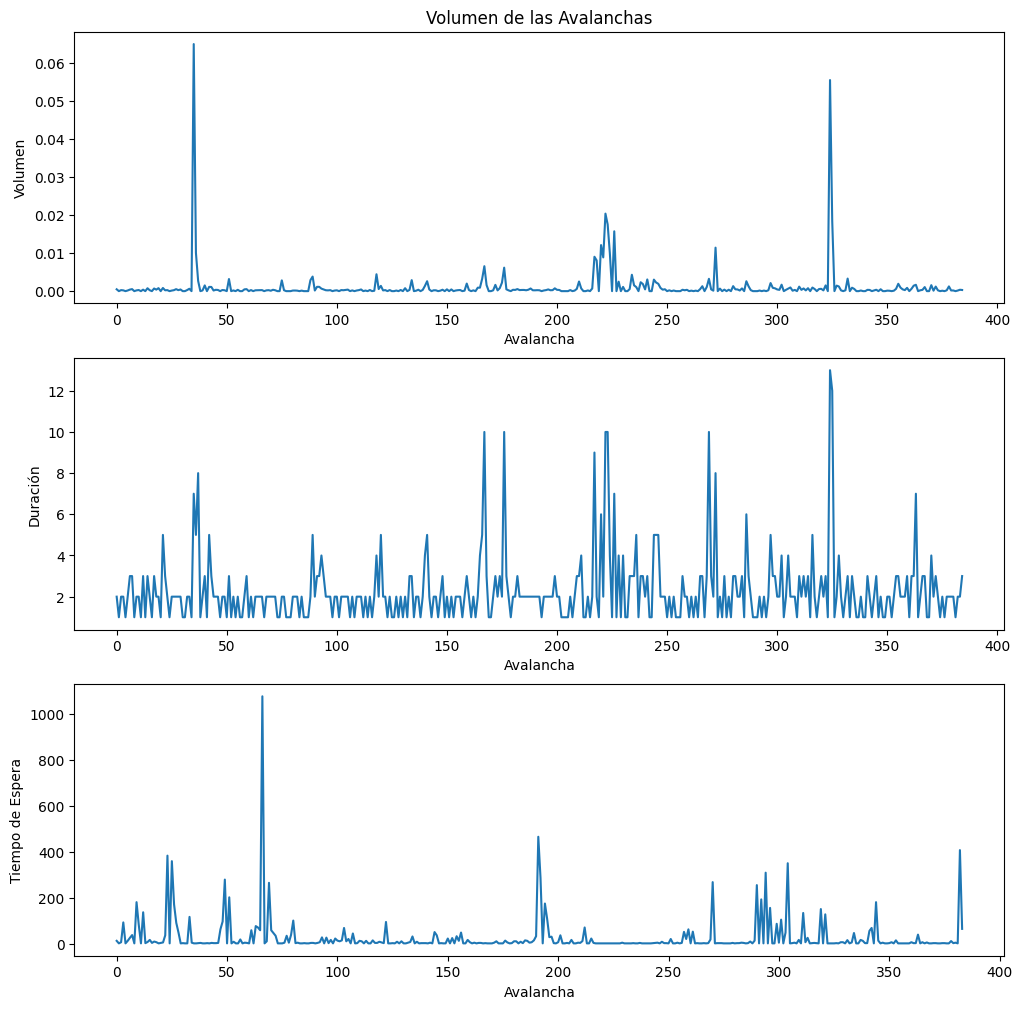

In [32]:
# Ploteo los volúmenes, duraciones y tiempos de espera
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

ax1.plot(volumenes)
ax1.set_xlabel('Avalancha')
ax1.set_ylabel('Volumen')
ax1.set_title('Volumen de las Avalanchas')

ax2.plot(duraciones)
ax2.set_xlabel('Avalancha')
ax2.set_ylabel('Duración')

ax3.plot(tiempos_espera)
ax3.set_xlabel('Avalancha')
ax3.set_ylabel('Tiempo de Espera')

plt.show()

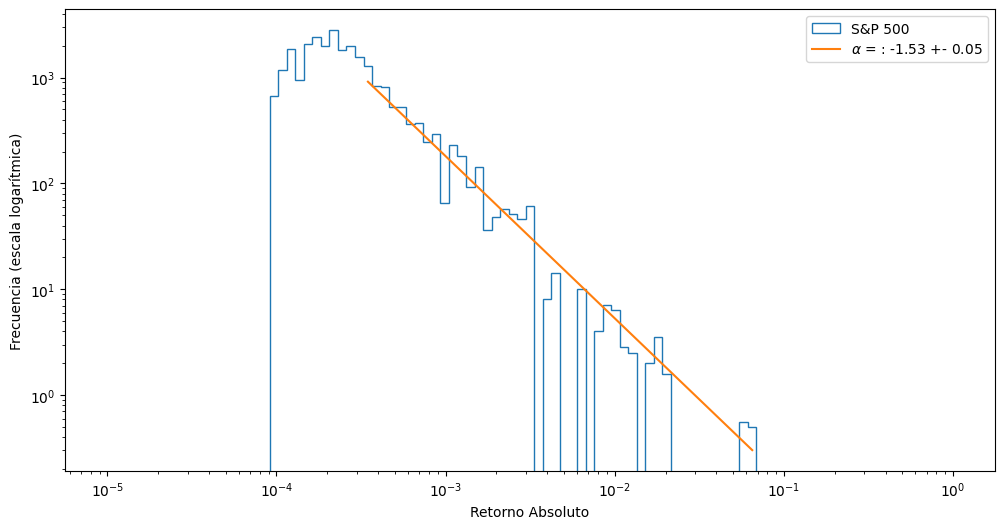

In [40]:
nbins = 100
bins = np.logspace(-5, 0, nbins)
plt.figure(figsize=(12, 6))
counts, bins, _ = plt.hist(volumenes, bins=bins, density=True, histtype='step', label="S&P 500")

x = (bins[:-1] + bins[1:]) / 2

# Ajustar una distribución de potencia a los datos
start = 30
end = nbins

x_fit = x[start:end]
y_fit = counts[start:end]

# Borro los valores 0 para que no haya problemas al hacer el ajuste
x_fit = x_fit[y_fit > 0]
y_fit = y_fit[y_fit > 0]

popt, pcov = np.polyfit(np.log(x_fit), np.log(y_fit), 1, cov=True)
alpha = -popt[0]
beta = np.exp(popt[1])

plt.plot(x_fit, beta * x_fit ** (-alpha), label=r'${\alpha}$ = 'f': {-alpha:.2f} +- {np.sqrt(pcov[0, 0]):.2f}')

plt.legend()


plt.xscale("log")
plt.yscale("log")

plt.xlabel("Retorno Absoluto")
plt.ylabel("Frecuencia (escala logarítmica)")

plt.show()

Y con el bitcoin?

[*********************100%***********************]  1 of 1 completed


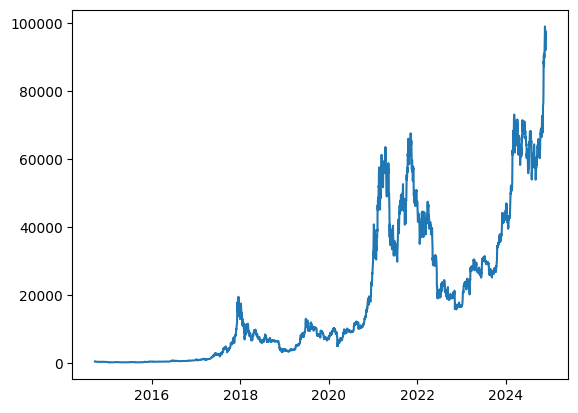

In [56]:
btc = yf.download("BTC-USD", start=None, end=None, interval="1d")

plt.plot(btc['Adj Close'])
# plt.yscale('log')

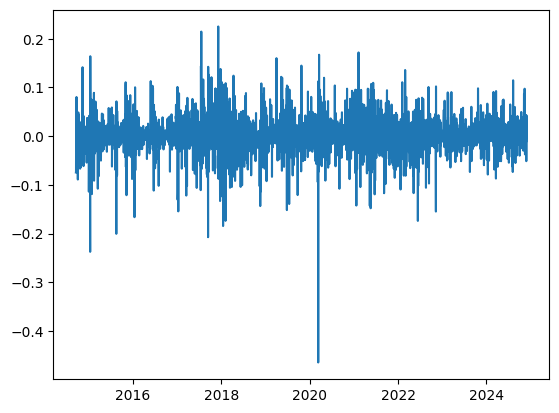

In [57]:
btc['Log Return'] = np.log(btc['Adj Close'] / btc['Adj Close'].shift(1))
btc.dropna(inplace=True)

plt.plot(btc['Log Return'])

Curtosis: 22.154377254036596
Asimetría: -1.1376861784315198


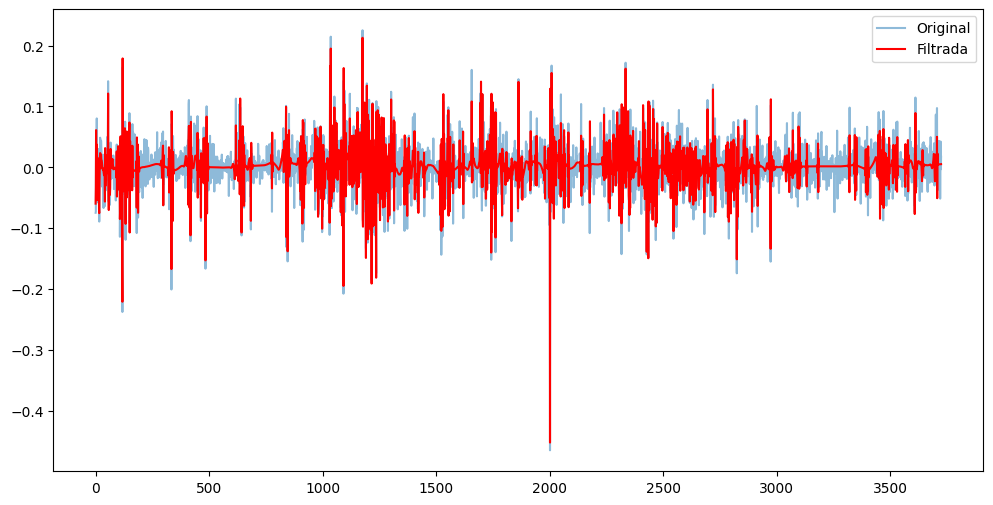

In [58]:
# Supón que 'log_returns' es tu serie temporal de retornos logarítmicos
log_returns = btc['Log Return'].values

# Realiza la descomposición wavelet con la wavelet Daubechies de orden 4
wavelet = 'db4'
coeffs = pywt.wavedec(log_returns, wavelet)

# Filtra los coeficientes eliminando los de baja energía
threshold = 0.25 * np.max(coeffs[-1])  # Ajusta este umbral según sea necesario
filtered_coeffs = [pywt.threshold(c, threshold, mode='hard') for c in coeffs]

# Reconstruye la serie temporal filtrada
filtered_log_returns = pywt.waverec(filtered_coeffs, wavelet)

kurtosis = stats.kurtosis(filtered_log_returns)
skewness = stats.skew(filtered_log_returns)
print("Curtosis:", kurtosis)
print("Asimetría:", skewness)

# Graficar la serie original y la filtrada
plt.figure(figsize=(12, 6))
plt.plot(log_returns, label='Original', alpha=0.5)
plt.plot(filtered_log_returns, label='Filtrada', color='red')
plt.legend()
plt.show()

In [61]:
epsilon = 0.001  # Ajusta este valor según sea necesario
indices_avalanchas = np.where(np.abs(filtered_log_returns) > epsilon)[0]

# Identificar periodos de avalanchas (donde los índices están contiguos)
avalanchas = []
inicio = indices_avalanchas[0]
for i in range(1, len(indices_avalanchas)):
    if indices_avalanchas[i] != indices_avalanchas[i - 1] + 1:
        avalanchas.append((inicio, indices_avalanchas[i - 1]))
        inicio = indices_avalanchas[i]
avalanchas.append((inicio, indices_avalanchas[-1]))  # Agregar la última avalancha


# Los volumenes se definen como la suma de los retornos al cuadrado
volumenes = []
for inicio, fin in avalanchas:
    volumen = np.sum(filtered_log_returns[inicio:fin]**2)
    volumenes.append(volumen)

duraciones = [fin - inicio + 1 for inicio, fin in avalanchas]
tiempos_espera = [
    avalanchas[i + 1][0] - avalanchas[i][1] for i in range(len(avalanchas) - 1)
]



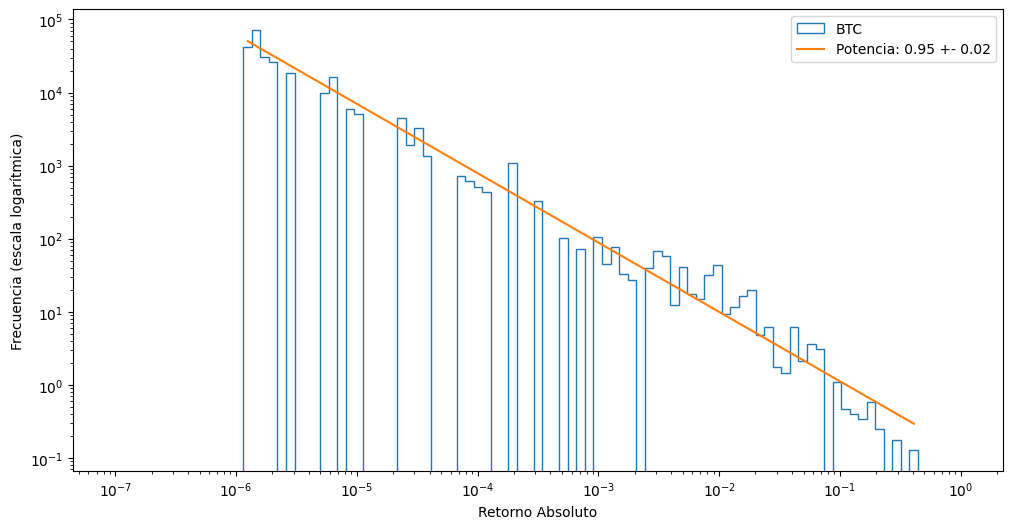

In [ ]:
bins = np.logspace(-7, 0, 100)
plt.figure(figsize=(12, 6))
counts, bins, _ = plt.hist(volumenes, bins=bins, density=True, histtype='step', label="BTC")

x = (bins[:-1] + bins[1:]) / 2

# Ajustar una distribución de potencia a los datos
start = 0
end = 100

x_fit = x[start:end]
y_fit = counts[start:end]

# Borro los valores 0 para que no haya problemas al hacer el ajuste
x_fit = x_fit[y_fit > 0]
y_fit = y_fit[y_fit > 0]

popt, pcov = np.polyfit(np.log(x_fit), np.log(y_fit), 1, cov=True)
alpha = -popt[0]
beta = np.exp(popt[1])

plt.plot(x_fit, beta * x_fit ** (-alpha), label=r'${\alpha}$ = 'f': {-alpha:.2f} +- {np.sqrt(pcov[0, 0]):.2f}')

plt.legend()


plt.xscale("log")
plt.yscale("log")

plt.xlabel("Retorno Absoluto")
plt.ylabel("Frecuencia (escala logarítmica)")

plt.show()